# MLCV Transferability Test: CLN025 → 2JOF

This notebook tests the transferability of MLCV models trained on CLN025 data by applying them to 2JOF data.
We will visualize the results using TICA plots colored by CV values and RMSD analysis.


In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import torch
import os
import pickle
from itertools import combinations
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Import functions from analysis-cv.py
import sys

class TICA_WRAPPER:
    """TICA wrapper for coordinate transformation."""
    def __init__(self, tica_model_path, pdb_path, tica_switch: bool = False):
        with open(tica_model_path, 'rb') as f:
            self.tica_model = pickle.load(f)
        self.pdb = md.load(pdb_path)
        self.ca_resid_pair = np.array(
            [(a.index, b.index) for a, b in combinations(list(self.pdb.topology.residues), 2)]
        )
        self.tica_switch = tica_switch
        self.r_0 = 0.8
        self.nn = 6
        self.mm = 12
        print(f"Loaded TICA model: {self.tica_model}")

    def transform(self, cad_data: np.ndarray):
        # if self.tica_switch:
        #     cad_data = (1 - np.power(cad_data / self.r_0, self.nn)) / (1 - np.power(cad_data / self.r_0, self.mm))
        tica_coord = self.tica_model.transform(cad_data)
        return tica_coord

    def pos2cad(self, pos_data: np.ndarray):
        self.pdb.xyz = pos_data
        ca_pair_distances, _ = md.compute_contacts(
            self.pdb, scheme="ca", contacts=self.ca_resid_pair, periodic=False
        )
        return ca_pair_distances

def compute_cv_values(
    mlcv_model,
    cad_torch,
    model_type,
    reference_cad=None,
    batch_size=10000,
):
    """Compute CV values from the model with optional sign flipping using batch processing."""
    dataset = TensorDataset(cad_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    print(f"Computing CV values in batches of {batch_size}...")
    
    with torch.no_grad():
        sample_batch = next(iter(dataloader))[0]
        sample_output = mlcv_model(sample_batch)
        output_dim = sample_output.shape[1]
    cv_batches = torch.zeros((len(cad_torch), output_dim)).to(cad_torch.device)
    
    with torch.no_grad():
        for batch_idx, (batch_data,) in enumerate(tqdm(
            dataloader,
            desc="Computing CV values",
            total=len(dataloader),
            leave=False,
        )):
            batch_cv = mlcv_model(batch_data)
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_cv.shape[0]  # Handle last batch size correctly
            cv_batches[start_idx:end_idx] = batch_cv
    
    cv = cv_batches.detach().cpu().numpy()
    MLCV_DIM = cv.shape[1]
    
    print(f"CV computation complete. Shape: {cv.shape}")
    
    if model_type == "mlcv":
        # Normalize CV values for MLCV
        cv_normalized = np.zeros_like(cv)
        
        for cv_dim in range(MLCV_DIM):
            cv_dim_val = cv[:, cv_dim]
            cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
            cv_range_mean = (cv_range_min + cv_range_max) / 2.0
            cv_range = (cv_range_max - cv_range_min) / 2.0
            cv_normalized[:, cv_dim] = (cv_dim_val - cv_range_mean) / cv_range
        
        cv = cv_normalized
        
    # Additional sign flipping based on reference structure
    if reference_cad is not None:
        with torch.no_grad():
            ref_cv = mlcv_model(torch.from_numpy(reference_cad).to(cad_torch.device))
            ref_cv = ref_cv.detach().cpu().numpy()
        
        # Normalize reference CV the same way
        if model_type == "mlcv":
            ref_cv_normalized = np.zeros_like(ref_cv)
            for cv_dim in range(MLCV_DIM):
                ref_cv_dim_val = ref_cv[:, cv_dim]
                cv_dim_val = cv[:, cv_dim]
                cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
                cv_range_mean = (cv_range_min + cv_range_max) / 2.0
                cv_range = (cv_range_max - cv_range_min) / 2.0
                ref_cv_normalized[:, cv_dim] = (ref_cv_dim_val - cv_range_mean) / cv_range
            ref_cv = ref_cv_normalized
        
        # Flip signs to ensure reference CV is positive
        for cv_dim in range(MLCV_DIM):
            if ref_cv[0, cv_dim] < 0:
                cv[:, cv_dim] = -cv[:, cv_dim]
                print(f"Flipped sign for CV dimension {cv_dim} to ensure positive reference value")
    
    return cv

def load_reference_structure(
    pdb_path,
    tica_wrapper,
):
    """Load reference structure and compute its CAD representation."""
    ref_traj = md.load(pdb_path)
    ref_pos = ref_traj.xyz[0]  # Get first (and only) frame
    ref_cad = tica_wrapper.pos2cad(ref_pos.reshape(1, -1, 3))
    return ref_cad


# Colors and settings
blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

# Set device
CUDA_DEVICE = 0
print(f"Using CUDA device: {CUDA_DEVICE}")


Using CUDA device: 0


# Load

## Load CLN025-trained Model and 2JOF Data


In [2]:
# Load CLN025-trained MLCV model
model_date = "0825_072649"
model_path = f"/home/shpark/prj-mlcv/lib/bioemu/model/{model_date}/mlcv_model-jit.pt"
mlcv_model = torch.jit.load(model_path, map_location=f"cuda:{CUDA_DEVICE}")
mlcv_model.eval()
print(f"Loaded CLN025-trained model from {model_path}")

# Load 2JOF data
test_molecule = "2JOF"
simulation_idx = 0

# Data paths for 2JOF
pos_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{test_molecule}-{simulation_idx}-protein/{test_molecule}-{simulation_idx}-pos.pt"
cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{test_molecule}-{simulation_idx}-protein/{test_molecule}-{simulation_idx}-cad.pt"
cad_switch_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{test_molecule}-{simulation_idx}-protein/{test_molecule}-{simulation_idx}-cad-switch.pt"

# Load data
pos_torch = torch.load(pos_path).to(f"cuda:{CUDA_DEVICE}")
cad_torch = torch.load(cad_path).to(f"cuda:{CUDA_DEVICE}")
cad_switch_torch = torch.load(cad_switch_path).to(f"cuda:{CUDA_DEVICE}")

print(f"Loaded {test_molecule} data:")
print(f"  Position data shape: {pos_torch.shape}")
print(f"  CAD data shape: {cad_torch.shape}")
print(f"  CAD switch data shape: {cad_switch_torch.shape}")


Loaded CLN025-trained model from /home/shpark/prj-mlcv/lib/bioemu/model/0825_072649/mlcv_model-jit.pt
Loaded 2JOF data:
  Position data shape: torch.Size([1044000, 272, 3])
  CAD data shape: torch.Size([1044000, 190])
  CAD switch data shape: torch.Size([1044000, 190])


## Setup TICA and Reference Structure


In [3]:
# Setup TICA wrapper for 2JOF
lag = 10
TICA_SWITCH = False  # 2JOF doesn't use switch

if TICA_SWITCH:
    tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{test_molecule}/{test_molecule}_tica_model_switch_lag{lag}.pkl"
else:
    tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{test_molecule}/{test_molecule}_tica_model_lag{lag}.pkl"

tica_wrapper = TICA_WRAPPER(
    tica_model_path=tica_model_path,
    pdb_path=f"/home/shpark/prj-mlcv/lib/DESRES/data/{test_molecule}/{test_molecule}_from_mae.pdb",
    tica_switch=TICA_SWITCH
)

print(f"Loaded TICA model for {test_molecule}")

# Load reference structure for 2JOF
reference_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{test_molecule}/folded.pdb"
reference_cad = None
if os.path.exists(reference_pdb_path):
    reference_cad = load_reference_structure(reference_pdb_path, tica_wrapper)
    print(f"Loaded reference structure from {reference_pdb_path}")
else:
    print(f"Reference structure not found, CV sign not aligned")


Loaded TICA model: TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=10,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)
Loaded TICA model for 2JOF
Loaded reference structure from /home/shpark/prj-mlcv/lib/DESRES/data/2JOF/folded.pdb


## Compute CV Values and TICA Coordinates


In [4]:
# Compute CV values using the CLN025-trained model on 2JOF data
cv = compute_cv_values(mlcv_model, cad_torch, "mlcv", reference_cad, batch_size=10000)
print(f"CV shape: {cv.shape}")
print(f"CV range: {cv.max():.4f} to {cv.min():.4f}")

# Compute TICA coordinates
if cad_torch.device.type == "cuda":
    cad_torch_cpu = cad_torch.cpu()
else:
    cad_torch_cpu = cad_torch
    
tica_data = tica_wrapper.transform(cad_torch_cpu.numpy())
print(f"TICA shape: {tica_data.shape}")


Computing CV values in batches of 10000...


CV computation complete. Shape: (1044000, 1)
CV shape: (1044000, 1)
CV range: 1.0000 to -1.0000
TICA shape: (1044000, 2)


# Eval

## Load RMSD Data


In [7]:
# Load RMSD data for 2JOF
rmsd_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{test_molecule}-0-protein/{test_molecule}-0-rmsd.pt"
# rmsd_unfolded_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{test_molecule}-0-protein/{test_molecule}-0-rmsd_unfolded.pt"

if os.path.exists(rmsd_path):
    rmsd = torch.load(rmsd_path).numpy()
    # rmsd_unfolded = torch.load(rmsd_unfolded_path).numpy()
    print(f"Loaded RMSD data for {test_molecule}")
    print(f"  RMSD to folded shape: {rmsd.shape}")
    # print(f"  RMSD to unfolded shape: {rmsd_unfolded.shape}")
    rmsd_available = True
else:
    print(f"RMSD data not found for {test_molecule}")
    rmsd_available = False


Loaded RMSD data for 2JOF
  RMSD to folded shape: (1044000,)


## Plot 1: TICA Plot Colored by CV Values


Plotting TICA-CV analysis for CV dimension 0


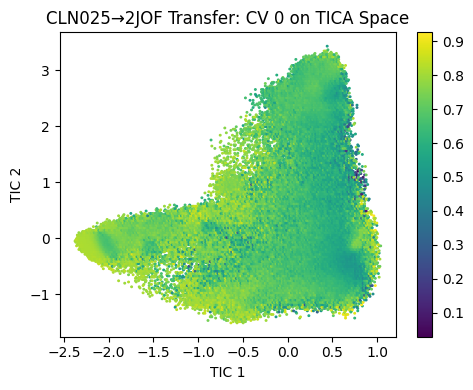

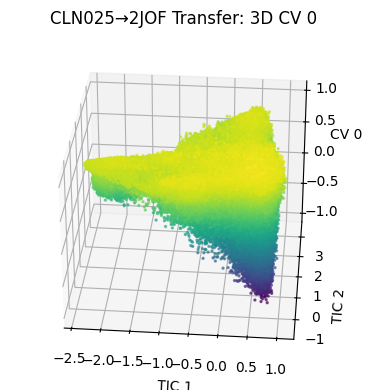

In [6]:
# TICA hexbin plot colored by CV values
MLCV_DIM = cv.shape[1]
x = tica_data[:, 0]
y = tica_data[:, 1]

for cv_dim in range(MLCV_DIM):
    print(f"Plotting TICA-CV analysis for CV dimension {cv_dim}")
    
    # 2D TICA hexbin plot
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111)
    hb = ax.hexbin(
        x, y, C=cv[:, cv_dim],
        gridsize=200,
        reduce_C_function=np.mean,
        cmap='viridis',
    )
    plt.colorbar(hb)
    plt.xlabel("TIC 1")
    plt.ylabel("TIC 2")
    plt.title(f"CLN025→{test_molecule} Transfer: CV {cv_dim} on TICA Space")
    plt.tight_layout()
    plt.show()
    
    # 3D scatter plot
    z = cv[:, cv_dim]
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=2, alpha=0.6)
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
    ax.set_zlabel(f'CV {cv_dim}')
    ax.set_title(f'CLN025→{test_molecule} Transfer: 3D CV {cv_dim}')
    ax.set_zticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax.view_init(azim=-85)
    
    plt.tight_layout()
    plt.show()


## Plot 2: RMSD Analysis


Plotting RMSD analysis for CV dimension 0


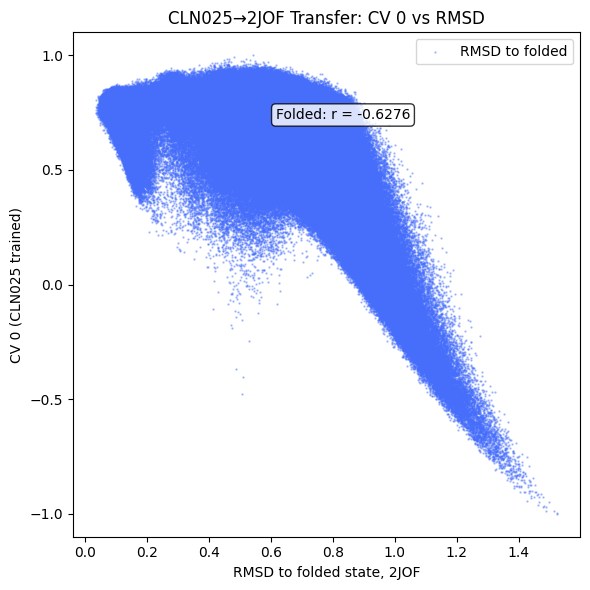

In [10]:
if rmsd_available:
    for cv_dim in range(MLCV_DIM):
        print(f"Plotting RMSD analysis for CV dimension {cv_dim}")
        
        # Scatter plot
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        ax.scatter(rmsd, cv[:, cv_dim], color=blue, s=0.5, alpha=0.4, zorder=1, label='RMSD to folded')
        # ax.scatter(rmsd_unfolded, cv[:, cv_dim], color=green, s=0.5, alpha=0.4, zorder=1, label='RMSD to unfolded')
        
        # Calculate Pearson correlation
        correlation_folded, p_value_folded = pearsonr(rmsd, cv[:, cv_dim])
        # correlation_unfolded, p_value_unfolded = pearsonr(rmsd_unfolded, cv[:, cv_dim])
        # correlation_text = f'Folded: r = {correlation_folded:.4f}\nUnfolded: r = {correlation_unfolded:.4f}'
        correlation_text = f'Folded: r = {correlation_folded:.4f}'
        ax.text(0.4, 0.85, correlation_text, transform=ax.transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top', fontsize=10)
        
        ax.set_xlabel(f"RMSD to folded state, {test_molecule}")
        ax.set_ylabel(f"CV {cv_dim} (CLN025 trained)")
        ax.set_title(f"CLN025→{test_molecule} Transfer: CV {cv_dim} vs RMSD")
        ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
        ax.legend()
        
        plt.tight_layout()
        plt.show()
else:
    print("RMSD data not available, skipping RMSD analysis")


## Summary Statistics


In [12]:
print("\n" + "="*60)
print(f"CLN025→{test_molecule} Transferability Analysis Summary")
print("="*60)

for cv_dim in range(MLCV_DIM):
    cv_values = cv[:, cv_dim]
    print(f"\nCV {cv_dim} Statistics:")
    print(f"  Mean: {np.mean(cv_values):.4f}")
    print(f"  Std: {np.std(cv_values):.4f}")
    print(f"  Min: {np.min(cv_values):.4f}")
    print(f"  Max: {np.max(cv_values):.4f}")
    print(f"  Range: {np.max(cv_values) - np.min(cv_values):.4f}")
    
    if rmsd_available:
        correlation_folded, _ = pearsonr(rmsd, cv_values)
        # correlation_unfolded, _ = pearsonr(rmsd_unfolded, cv_values)
        print(f"  Correlation with RMSD to folded: {correlation_folded:.4f}")
        # print(f"  Correlation with RMSD to unfolded: {correlation_unfolded:.4f}")

print(f"\nTICA Statistics:")
print(f"  TIC 1 - Mean: {np.mean(tica_data[:, 0]):.4f}, Std: {np.std(tica_data[:, 0]):.4f}")
print(f"  TIC 2 - Mean: {np.mean(tica_data[:, 1]):.4f}, Std: {np.std(tica_data[:, 1]):.4f}")

if rmsd_available:
    print(f"\nRMSD Statistics:")
    print(f"  RMSD to folded - Mean: {np.mean(rmsd):.4f}, Std: {np.std(rmsd):.4f}")
    # print(f"  RMSD to unfolded - Mean: {np.mean(rmsd_unfolded):.4f}, Std: {np.std(rmsd_unfolded):.4f}")


CLN025→2JOF Transferability Analysis Summary

CV 0 Statistics:
  Mean: 0.6346
  Std: 0.2301
  Min: -1.0000
  Max: 1.0000
  Range: 2.0000
  Correlation with RMSD to folded: -0.6276

TICA Statistics:
  TIC 1 - Mean: -0.0000, Std: 0.9870
  TIC 2 - Mean: -0.0000, Std: 0.9555

RMSD Statistics:
  RMSD to folded - Mean: 0.5569, Std: 0.2466
